In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression
from scipy.signal import butter, filtfilt, lfilter, iirfilter
import xrscipy.signal as dsp

import gsw
from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite
from qc import qc_turbulence

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")

In [6]:
def qc_turbulence(data):
    '''
    clean chi and eps with RC's scripts
    '''
    # infile = 'data/xarray/xr_7784b.nc'
    # data = xr.open_dataset(str(infile))

    dtdzmin = 1.5e-3
    chimax = 5e-5
    kTmax = 1e-1
    zmin = 0 # disabled
    # for ratios
    lb = 0.5
    ub = 2

    floats = np.array([
        '7779a', '7781a', '7783a', '7786a', '7787a', '7788a',
        '7700b', '7701b','7780b', '7784b', '7785b', '7786b'
    ])
    fi = np.where(floats == data.floatid)[0][0]
    good_chi1, good_chi2 = np.load('../data/xarray/good_chi.npy')

#     # 1) thresholds for chi
#     data['dtdz1'] = np.sqrt(0.5 * data.chi1 / data.kT1)
#     data['dtdz2'] = np.sqrt(0.5 * data.chi2 / data.kT2)

#     bad = (data.dtdz1 <= dtdzmin) | (data.chi1 >= chimax) | (data.kT1 >= kTmax)
#     data['chi1'] = data['chi1'].where(~bad)
#     data['kT1'] = data['kT1'].where(~bad)
#     data['eps1'] = data['eps1'].where(~bad)

#     bad = (data.dtdz2 <= dtdzmin) | (data.chi2 >= chimax) | (data.kT2 >= kTmax)
#     data['chi2'] = data['chi2'].where(~bad)
#     data['kT2'] = data['kT2'].where(~bad)
#     data['eps2'] = data['eps2'].where(~bad)

#     # 2) periods of functioning chi sensor
#     tmin, tmax = str2date(good_chi1[fi, 0]), str2date(good_chi1[fi, 1])
#     bad = (data.time < tmin) | (data.time > tmax)
#     data['chi1'] = data['chi1'].where(~bad)
#     data['kT1'] = data['kT1'].where(~bad)
#     data['eps1'] = data['eps1'].where(~bad)

#     tmin, tmax = str2date(good_chi2[fi, 0]), str2date(good_chi2[fi, 1])
#     bad = (data.time < tmin) | (data.time > tmax)
#     data['chi2'] = data['chi2'].where(~bad)
#     data['kT2'] = data['kT2'].where(~bad)
#     data['eps2'] = data['eps2'].where(~bad)

    # 3) compare two sensors
    def combine_fun(array1, array2, lb=lb, ub=ub):
        ratio = array1 / array2
        bad = (ratio <= lb) | (ratio >= ub)

        chi1fin = np.isfinite(array1)
        chi2fin = np.isfinite(array2)

        a1 = np.minimum(array1.where(bad & chi1fin),
                        array2.where(bad & chi1fin))
        a2 = np.minimum(array1.where(bad & chi2fin),
                        array2.where(bad & chi2fin))
        a3 = avg_funs(array1.where(~bad), array2.where(~bad))

        concat = xr.concat([a1, a2, a3], dim='temp')
        return concat.mean(dim='temp')

    data['kT'] = combine_fun(data.kT1, data.kT2)
    data['chi'] = combine_fun(data.chi1, data.chi2)
    data['eps'] = combine_fun(data.eps1, data.eps2)

#     data = data.drop(
#         ['eps1', 'eps2', 'chi1', 'chi2', 'kT1', 'kT2', 'dtdz1', 'dtdz2'])
    return data

In [7]:
def qc_velocity(data):
    '''
    qc EM velocity measurements based on vertical movement and rotation rate of the float
    '''
    Wmin = 0.05
    RotPmax = 20
    verrmax = 0.1 # original 0.02

    # where cond:  what to keep!
    uv_mask = (np.abs(data.W) > Wmin) & (data.RotP < RotPmax)
    u1_mask = uv_mask & (data.verr1 < verrmax)
    u2_mask = uv_mask & (data.verr2 < verrmax)

    data['u1'] = data.u1.where(u1_mask)
    data['u2'] = data.u2.where(u2_mask)
    data['v1'] = data.u1.where(u1_mask)
    data['v2'] = data.v2.where(u2_mask)

    data['u'] = avg_funs(data['u1'], data['u2'])
    data['v'] = avg_funs(data['v1'], data['v2'])
    data['dudz'] = avg_funs(data['du1dz'], data['du2dz'])
    data['dvdz'] = avg_funs(data['dv1dz'], data['dv2dz'])
    data['S2'] = data.dudz**2 + data.dvdz**2

    data = data.drop([
        'W', 'RotP', 'verr1', 'verr2', 'u1', 'u2', 'v1', 'v2', 'du1dz',
        'du2dz', 'dv1dz', 'dv2dz'
    ])
    return data

def integrate_columns(data,lower,upper):
    '''
        Integrate each profile over depth range, e.g., MLD to 0.
    '''
    # mld=data.mld
    data = data.where( (data.z >= lower) & (data.z < upper) )
    data['z'] = data.z * (-1)
    array = []
    for t in range(data.time.size):
        # TODO: could do better here with simpson's rule
        if data.isel(time=t).dropna('z').size > 3:
            array.append(data.isel(time=t).dropna('z').integrate('z'))
        else:
            array.append(data.isel(time=t).dropna('z').integrate('z')*np.nan)

    # find zmin observed depth
    if np.mean(upper)==0:
        zmin = data[first_finite(data,0)].z
    else:
        zmin = upper
    xr.concat(array/(lower-zmin), dim='time')
#     xr.concat(array, dim='time')
    return xr.concat(array/(lower-zmin), dim='time')

In [712]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
raw = qc_turbulence(raw)
raw = qc_velocity(raw)

In [745]:
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['Ri'] = raw.n2/raw.S2

# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0).fillna(0).astype(int)
indv = first_finite(raw.v, 0).fillna(0).astype(int)

raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

indS = first_finite(raw.S, 0).fillna(0).astype(int)
indT = first_finite(raw.T, 0).fillna(0).astype(int)
raw['S_surf'] = 0.5*(raw.S[indS]+raw.S[indS+1])
raw['T_surf'] = 0.5*(raw.T[indT]+raw.T[indT+1])

In [928]:
def bandpass_velocity(raw):
    import xrscipy.signal as dsp
    
    lat_mean = raw.lat.mean()
    
    # convert datetime to seconds since t=0
    raw['dtime'] = (raw.time - raw.time.isel(time=0))*1e-9
    # make dtime a dimension
    raw = raw.swap_dims({'time':'dtime'})
    
    # filtering proceduce
    # determine sampling timestep and Nyquist frequency
    fs = ( dsp.get_sampling_step(raw, dim='time')*1e-9 )
    ny = 2*np.pi/fs
    
    # limits for bandpass
    low_f = gsw.f(lat_mean)*0.75 # in 1/s
    high_f = gsw.f(lat_mean)*1.25 # in 1/s
    eps=0 # how to fill nans
    # pick an order?
    ulow = dsp.bandpass(raw.u.fillna(eps), low_f/ny, high_f/ny, dim='dtime', in_nyq=True, order=4)
    vlow = dsp.bandpass(raw.v.fillna(eps), low_f/ny, high_f/ny, dim='dtime', in_nyq=True, order=4)
    
    # swap dims back
    ulow = ulow.swap_dims({'dtime':'time'})
    vlow = vlow.swap_dims({'dtime':'time'})
    raw = raw.swap_dims({'dtime':'time'})

    # remove time and space means?
    ulow = ulow #- ulow.mean(dim='z') - ulow.mean(dim='time')
    vlow = vlow #- vlow.mean(dim='z') - ulow.mean(dim='time')
    
    return ulow, vlow

## Bandpass filter the velocity

In [929]:
ulow, vlow = bandpass_velocity(raw)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UnevenSamplingWarning: Average sampling 9.94e+12 != first sampling step 2.23e+12
  del sys.path[0]


(-200, 0)

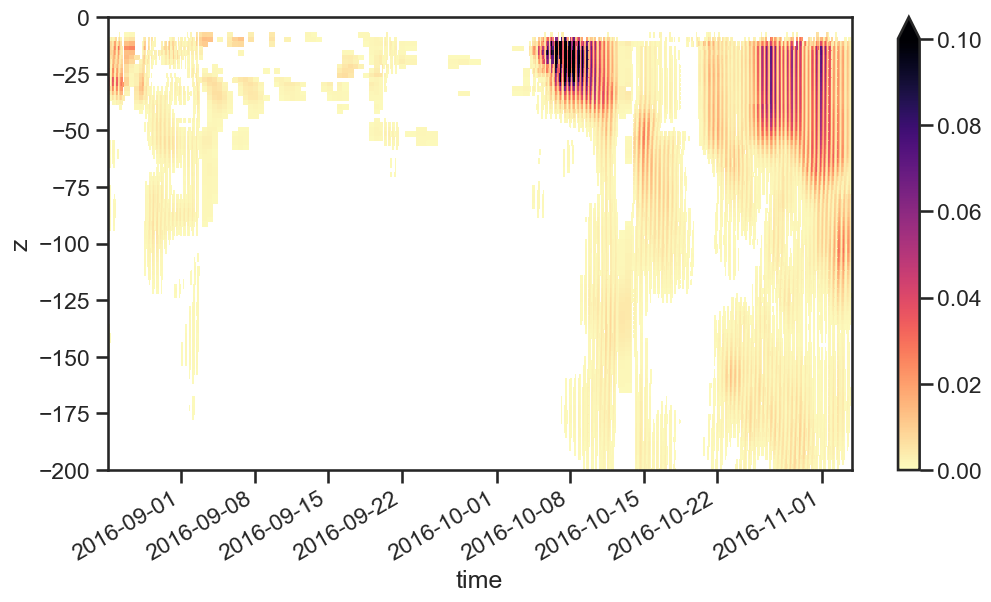

In [930]:
hke = 0.5*(ulow**2 + vlow**2)
# hke = hke.swap_dims({'dtime':'time'})
hke.where(hke>0.001).where(mask).plot(cmap='magma_r',vmin=0, vmax=0.1)
plt.ylim(-200,0)

(-200, 0)

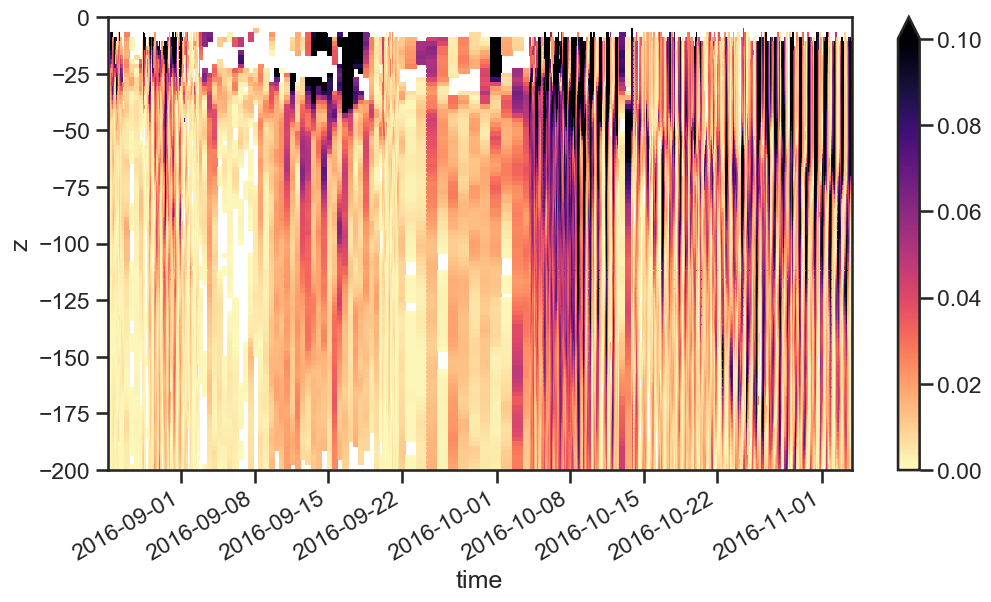

In [931]:
hke_tot = 0.5*(raw.u**2 + raw.v**2) #- hke
# hke = hke.swap_dims({'dtime':'time'})
hke_tot.where(hke_tot>0.001).where(mask).plot(cmap='magma_r',vmin=0, vmax=0.1)
plt.ylim(-200,0)

In [932]:
ang = np.arctan2(vlow, ulow)

In [933]:
ref_time = pd.to_datetime('12/28/1988')
timestamp = pd.to_datetime(ang.time.values)

Tf = 2 * np.pi / gsw.f(40)
dt = (timestamp - ref_time) / pd.to_timedelta(1, unit='s') % Tf

phase_add = (dt.values * gsw.f(40)).astype('float')
phase_add[phase_add > np.pi] = phase_add[phase_add > np.pi] - 2 * np.pi

ang_br = ang + phase_add
ang_br = xr.where( ang_br > np.pi, (ang_br.where(ang_br > np.pi) - np.pi), ang_br)
ang_br = xr.where( ang_br < -np.pi, 2 * np.pi + (ang_br.where(ang_br > np.pi)),ang_br)

In [934]:
mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)

(-500, 0)

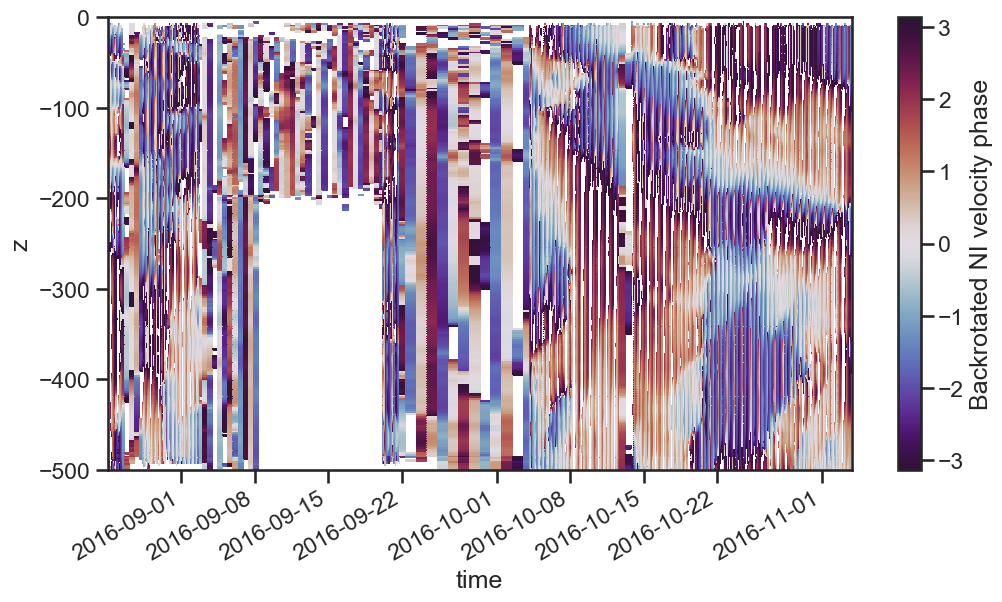

In [935]:
ang_br.where(mask).plot(cmap='twilight_shifted',cbar_kwargs={'label':'Backrotated NI velocity phase'})
plt.ylim(-500,0)

In [936]:
dudz_tot = raw.u.differentiate('z')
dvdz_tot = raw.v.differentiate('z')
S_tot = 0.5*(dudz_tot**2 + dvdz_tot**2)

(-200, 0)

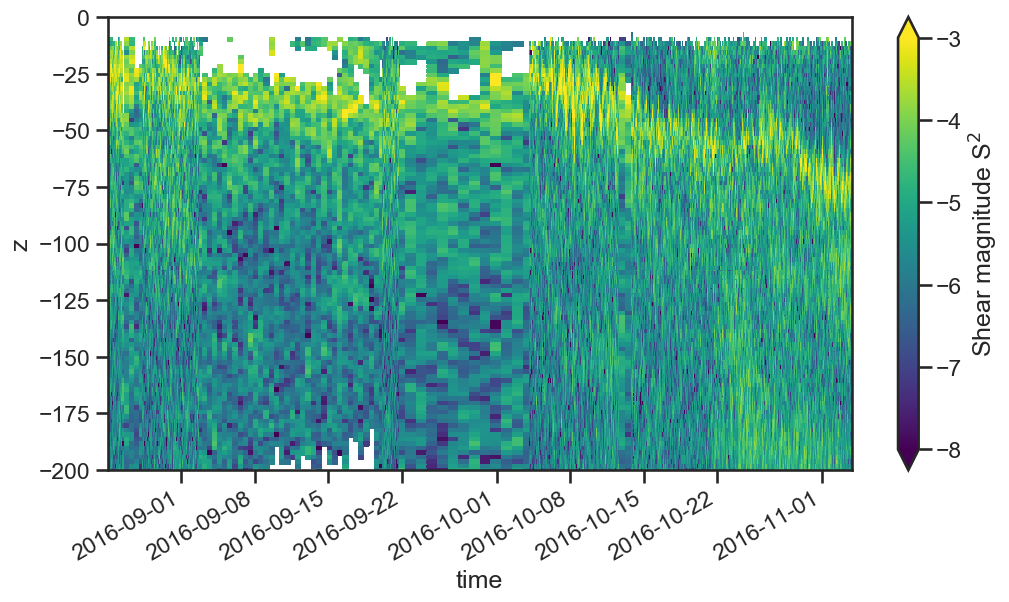

In [937]:
S_tot.pipe(np.log10).where(mask).plot(vmin=-8, vmax=-3,cbar_kwargs={'label':'Shear magnitude S$^2$'})
plt.ylim(-200,0)

In [938]:
dudz = ulow.differentiate('z')
dvdz = vlow.differentiate('z')
S = 0.5*(dudz**2 + dvdz**2)

(-200, 0)

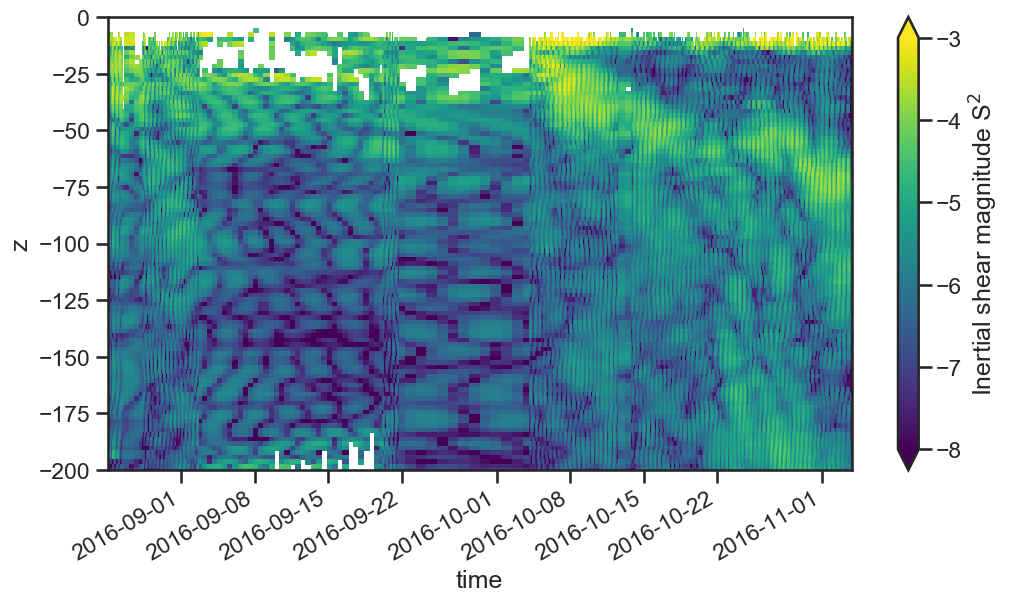

In [939]:
S.pipe(np.log10).where(mask).plot(vmin=-8, vmax=-3,cbar_kwargs={'label':'Inertial shear magnitude S$^2$'})
plt.ylim(-200,0)

In [940]:
angS = np.arctan2(dvdz, dudz)

In [962]:
def backrotate_phase(ang):
    ref_time = pd.to_datetime('12/28/1988')
    timestamp = pd.to_datetime(ang.time.values)

    Tf = 2 * np.pi / gsw.f(40.7)
    dt = (timestamp - ref_time) / pd.to_timedelta(1, unit='s') % Tf

    phase_add = (dt.values * gsw.f(40.7)).astype('float')
    phase_add[phase_add > np.pi] = phase_add[phase_add > np.pi] - 2 * np.pi

    ang_br = ang + phase_add
    ang_br = xr.where( ang_br > np.pi, (ang_br.where(ang_br > np.pi) - np.pi), ang_br)
    ang_br = xr.where( ang_br < -np.pi, 2 * np.pi + (ang_br.where(ang_br > np.pi)),ang_br)
    return ang_br

In [963]:
angS_br = backrotate_phase(angS).sel(time=slice('2016-10-01','2016-11-05'))

Text(0.5, 0, '')

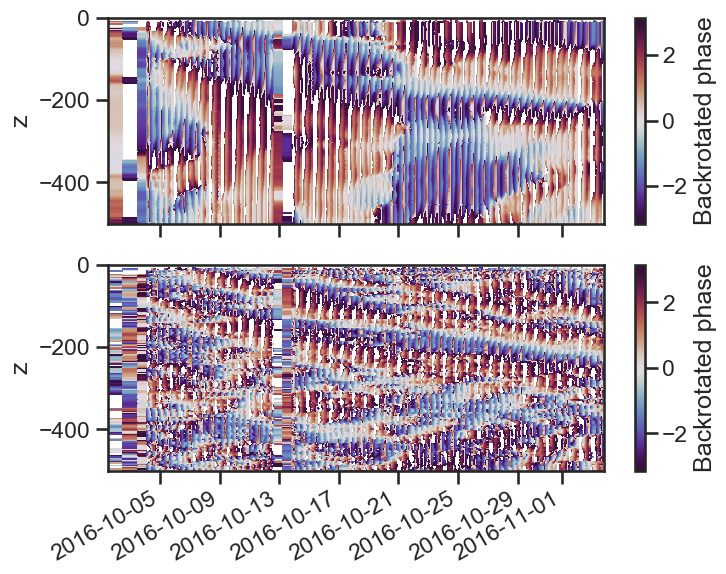

In [964]:
f, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

ang_br.where(mask).plot(ax=ax[0],cmap='twilight_shifted',cbar_kwargs={'label':'Backrotated phase'})
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)


angS_br.where(mask).plot(ax=ax[1],cmap='twilight_shifted',cbar_kwargs={'label':'Backrotated phase'})
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)